In [316]:
%%bigquery udf --module extract_tokens

/**
 * @param {{tweet_object: string, polarity: float, magnitude: float, syntax:string }} r
 * @param function({{type: string, content:string}}) emitFn
 */
function(r, emitFn) {
  try{
    var tweet = JSON.parse(r.tweet_object);
    var syntax = JSON.parse(r.syntax);
    var trump=false, clinton=true;
    syntax.forEach(function(token){
      if(token.content !== "&amp" && token.content!== "#")
        emitFn({type : token.partOfSpeech, content : token.content.toLowerCase()})
    })
  }
  catch(e){
  }  
}


In [317]:
%%sql --module words
#Colorado, Florida, Iowa, Michigan, Nevada, New Hampshire, North Carolina, Ohio, Pennsylvania, Virginia and Wisconsin.
part_of_speech="NOUN"
SELECT content, count(*) as rate FROM extract_tokens(SELECT * FROM [in-full-gear:Dataset1.Sep25] WHERE NOT REGEXP_MATCH(tweet_object, "GoogleJsonResponseException"))
where type=$part_of_speech
group by content
order by rate desc
limit 10
#where place in ("CO", "FL", "IA", "MI", "NV", "NG", "NC", "OH", "PA", "VA", "WI")

In [318]:
import datalab.bigquery as bq
adjectives =  bq.Query(words, udf=extract_tokens, part_of_speech="ADJ");

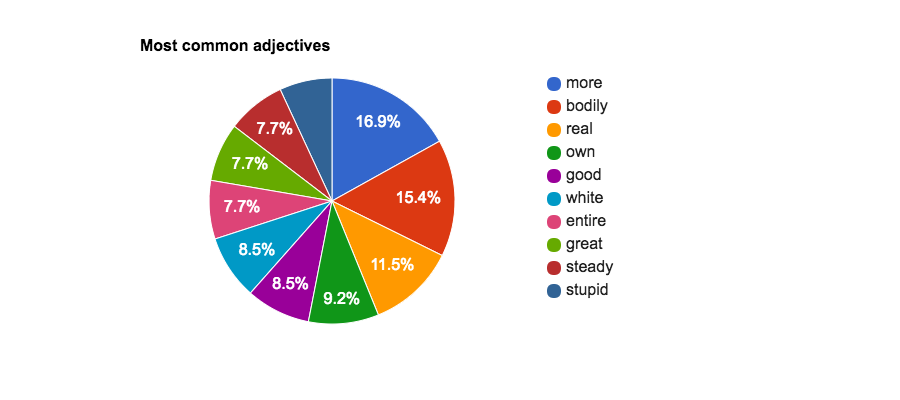

In [319]:
%%chart pie --data adjectives
title: Most common adjectives
height: 400
width: 900

In [320]:
nouns =  bq.Query(words, udf=extract_tokens, part_of_speech="NOUN");

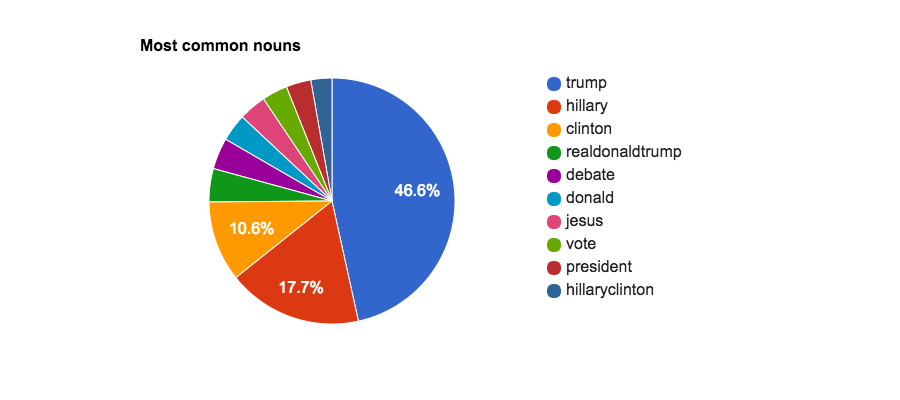

In [321]:
%%chart pie --data nouns
title: Most common nouns
height: 400
width: 900

In [322]:
%%bigquery udf --module parse_topics

function getStateName(placeName){
  return placeName.substring(placeName.indexOf(',') + 1).trim();
}

/**
 * @param {{tweet_object: string, polarity: float, magnitude: float, syntax:string }} r
 * @param function({{place:string, topic: string, polarity:float, magnitude:float, text:string}}) emitFn
 */
function(r, emitFn) {
  try{
    var tweet = JSON.parse(r.tweet_object);
    var syntax = JSON.parse(r.syntax);
    var trump = false, clinton = false;
    syntax.forEach(function(token){
      switch(token.content.toLowerCase()){
        case "trump" : 
        case "realdonaldtrump" :
        case "donald" :
          trump = true; break;
        case "hillary" :
        case "clinton" :
        case "hillaryclinton":
          clinton = true;break;          
      }
    })
    var topic = 'common';
    if(trump && !clinton)
      var topic = 'trump';
    else if(clinton && !trump)
      var topic = 'clinton';
    //emitFn({topic : topic, polarity: r.polarity, magnitude: r.magnitude, text : tweet.text});
    if(tweet && tweet.place && tweet.place.place_type==='city')
      emitFn({topic:topic, place : getStateName(tweet.place.full_name), polarity: r.polarity, magnitude: r.magnitude});
  }
  catch(e){
  }  
}

In [323]:
%%sql --module sentiment
topic = "trump"
place = "CO"
#Colorado, Florida, Iowa, Michigan, Nevada, New Hampshire, North Carolina, Ohio, Pennsylvania, Virginia and Wisconsin.

SELECT polarity, magnitude FROM parse_topics(SELECT * FROM [in-full-gear:Dataset1.Sep25] WHERE NOT REGEXP_MATCH(tweet_object, "GoogleJsonResponseException"))
where topic = $topic and place=$place
#where place in ("CO", "FL", "IA", "MI", "NV", "NG", "NC", "OH", "PA", "VA", "WI")

In [330]:
trump_co_sentiments =  bq.Query(sentiment, udf=parse_topics, topic="trump", place="NV");
#q.results(use_cache = False)

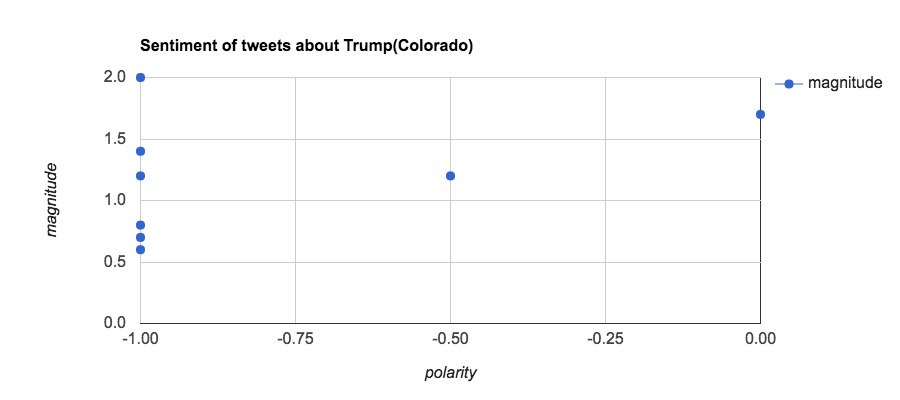

In [331]:
%%chart scatter --data trump_co_sentiments
title: Sentiment of tweets about Trump(Colorado)
height: 400
width: 900
hAxis:
  title: polarity
vAxis:
  title: magnitude